#### Distances analysis (different metrics)

In [28]:
%load_ext autotime
import sys, os
print(os.getcwd())
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import pysal
import contextily

import osmnx as ox
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

from scipy.spatial.distance import euclidean
import datetime

from tqdm.notebook import tqdm
import random
from geopy import distance
import haversine as hs
import networkx as nx

from dao.connector import Connector

import mlflow
from datetime import datetime
import logging
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('exceptions/exceptions_handler.log', mode="w+", encoding=None, delay=False)
file_handler.setLevel(level=logging.DEBUG)
file_handler.setFormatter(formatter)
logging.getLogger().addHandler(file_handler)

import warnings
warnings.filterwarnings("ignore")

SEED = 6543210
TEST_SIZE = 0.0001
CURR_PREC = 4
R = 6371 # Earth radius
INF = 999999

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
/Users/temporaryadmin/Documents/GitHub/ml_cheat_sheet/Geographic
time: 142 ms (started: 2022-07-21 12:26:41 +02:00)


In [29]:
def _to_cartesian(loc_degrees):
    '''
    loc_degrees = (lat, lon)
    '''
    R = 6371*10**3
    loc = np.radians(loc_degrees[0]), np.radians(loc_degrees[1])
    return R*np.cos(loc[0])*np.cos(loc[1]), R*np.sin(loc[1])*np.cos(loc[0]), R*np.sin(loc[0])

def _to_cartesian_df(loc, col = ['lon','lat']):
    '''
    loc = lon, lat
    '''
    R = 6371
    return R*np.cos(loc[col[0]])*np.cos(loc[col[1]]), \
        R*np.sin(loc[col[1]])*np.cos(loc[col[0]]), R*np.sin(loc[col[0]])

def get_distance(x, method = 'haversine'):
    '''
    x - dataframe row with columns:
        * lat_cluster, lon_cluster (degrees)
        * next_lat_cluster, lon_next_cluster (degrees)
    Return:
        * Distance in meters
    '''
    if x.next_lat_cluster == -1:
        return 0
    if method == 'haversine':
        return hs.haversine((float(x.lat_cluster), float(x.lon_cluster))\
                , (float(x.next_lat_cluster), float(x.next_lon_cluster)))*1e3
    elif method == 'manhattan':
        loc_1 = _to_cartesian((float(x.lat_cluster), float(x.lon_cluster)))
        loc_2 = _to_cartesian((float(x.next_lat_cluster), float(x.next_lon_cluster)))
        return np.abs(loc_1[0] - loc_2[0]) + \
            np.abs(loc_1[1] - loc_2[1]) + np.abs(loc_1[2] - loc_2[2])
    elif method == 'euclidean':
        loc_1 = _to_cartesian((float(x.lat_cluster), float(x.lon_cluster)))
        loc_2 = _to_cartesian((float(x.next_lat_cluster), float(x.next_lon_cluster)))
        return np.sqrt((loc_1[0] - loc_2[0])**2 + \
            (loc_1[1] - loc_2[1])**2 + (loc_1[2] - loc_2[2])**2)
    sys.exit()

def __distance_measure(v_1, v_2, coords = False, method = 'euclidean'):
    '''
    Multiple distances
    Multiple dimensional
    '''
    def __hav(d):
        return (1 - np.cos(d))/2
    R = 6371*10**3
    if method == 'haversine':
        assert coords
        hav = 2*R*np.arcsin(np.sqrt(__hav(np.radians(v_1[0] - v_2[0]))\
            + (1 - __hav(np.radians(v_2[0] - v_1[0])) \
                - __hav(np.radians(v_2[0] + v_1[0])))\
                    * __hav(np.radians(v_1[1] - v_2[1])))
            )
        print('Haversine custom: ',hav)
        return hs.haversine(v_1, v_2)*1e3
    if coords:
        v_1,v_2 = _to_cartesian(v_1), _to_cartesian(v_2)
        print(v_1, v_2)
    distance = 0.
    for i, _ in enumerate(v_1):
        if method == 'euclidean':
            distance += (v_1[i] - v_2[i])**2
        elif method == 'manhattan':
            distance += np.abs((v_1[i] - v_2[i]))
    return np.sqrt(distance) if method == 'euclidean' else distance


time: 15.2 ms (started: 2022-07-21 12:26:42 +02:00)


In [30]:
NUM_ROWS_ANALYSIS = 1e5
connector = Connector()
df = connector.get_data_file('big_query_queries/points_rides.sql')
# df = pd.read_parquet("location_for_agglines.gzip")
df['date_creation'] = pd.to_datetime(df.created_at, infer_datetime_format=True)
df['doy'] = df.date_creation.dt.dayofyear
df['year'] = df.date_creation.dt.year
df.lon, df.lat = df.lon.round(decimals = CURR_PREC), df.lat.round(decimals = CURR_PREC)
df.next_lon, df.next_lat = df.next_lon.round(decimals = CURR_PREC), df.next_lat.round(decimals = CURR_PREC)
df['lon_rad'], df['lat_rad'] = np.radians(df.lon), np.radians(df.lat)
df['idx'] = list(range(df.shape[0]))

time: 2min 19s (started: 2022-07-21 12:26:42 +02:00)


In [31]:
print(df.columns.values)
#df_test = df.sample(frac = TEST_SIZE)
#df = df.loc[~df.idx.isin(df_test.idx)]
df[['lat_cluster','lon_cluster','next_lat_cluster','next_lon_cluster']] = list(zip(df.lat, df.lon, df.next_lat, df.next_lon)) 
df = df.iloc[0:int(NUM_ROWS_ANALYSIS)]
df.head()

['rider_id' 'order_id' 'created_at' 'lat' 'lon' 'next_lon' 'next_lat' 'dt'
 'dx' 'accuracy' 'speed' 'zone_id' 'date_creation' 'doy' 'year' 'lon_rad'
 'lat_rad' 'idx']


,rider_id,order_id,created_at,lat,lon,next_lon,next_lat,dt,dx,accuracy,...,date_creation,doy,year,lon_rad,lat_rad,idx,lat_cluster,lon_cluster,next_lat_cluster,next_lon_cluster
0,44970,45225552,2022-06-01 08:54:54+00:00,25.2478,51.5598,-1.0000,-1.0000,<NA>,NaN,3.79,...,2022-06-01 08:54:54+00:00,152,2022,0.899888,0.440657,0,25.2478,51.5598,-1.0000,-1.0000
1,44970,45225552,2022-06-01 08:55:13+00:00,25.2481,51.5599,51.5598,25.2478,19,44.452098,3.79,...,2022-06-01 08:55:13+00:00,152,2022,0.899890,0.440662,1,25.2481,51.5599,25.2478,51.5598
2,44970,45225552,2022-06-01 08:55:42+00:00,25.2488,51.5595,51.5599,25.2481,29,79.960928,3.79,...,2022-06-01 08:55:42+00:00,152,2022,0.899883,0.440675,2,25.2488,51.5595,25.2481,51.5599
3,44970,45225552,2022-06-01 08:56:14+00:00,25.2491,51.5593,51.5595,25.2488,32,48.267785,3.79,...,2022-06-01 08:56:14+00:00,152,2022,0.899880,0.440680,3,25.2491,51.5593,25.2488,51.5595
4,44970,45225552,2022-06-01 08:56:45+00:00,25.2500,51.5604,51.5593,25.2491,31,144.043612,3.79,...,2022-06-01 08:56:45+00:00,152,2022,0.899899,0.440696,4,25.2500,51.5604,25.2491,51.5593


time: 1.28 s (started: 2022-07-21 12:32:37 +02:00)


In [32]:
df['custom_distance_manhattan'] = df.apply(get_distance, axis = 1, method = ('manhattan'))
df['custom_distance_haversine'] = df.apply(get_distance, axis = 1, method = ('haversine'))
df['custom_distance_euclidean'] = df.apply(get_distance, axis = 1, method = ('euclidean'))
# Error absoluto
df['abs_manhattan_error'] = np.abs(df.custom_distance_manhattan - df.dx)
df['abs_haversine_error'] = np.abs(df.custom_distance_haversine - df.dx)
df['abs_euclidean_error'] = np.abs(df.custom_distance_euclidean - df.dx)
# Error real
df['manhattan_error'] = df.custom_distance_manhattan - df.dx
df['haversine_error'] = df.custom_distance_haversine - df.dx
df['euclidean_error'] = df.custom_distance_euclidean - df.dx
# Filter
df_filtered = df.loc[df.dx <= df.dx.mean()+5*df.dx.std()]

time: 19 s (started: 2022-07-21 12:33:09 +02:00)


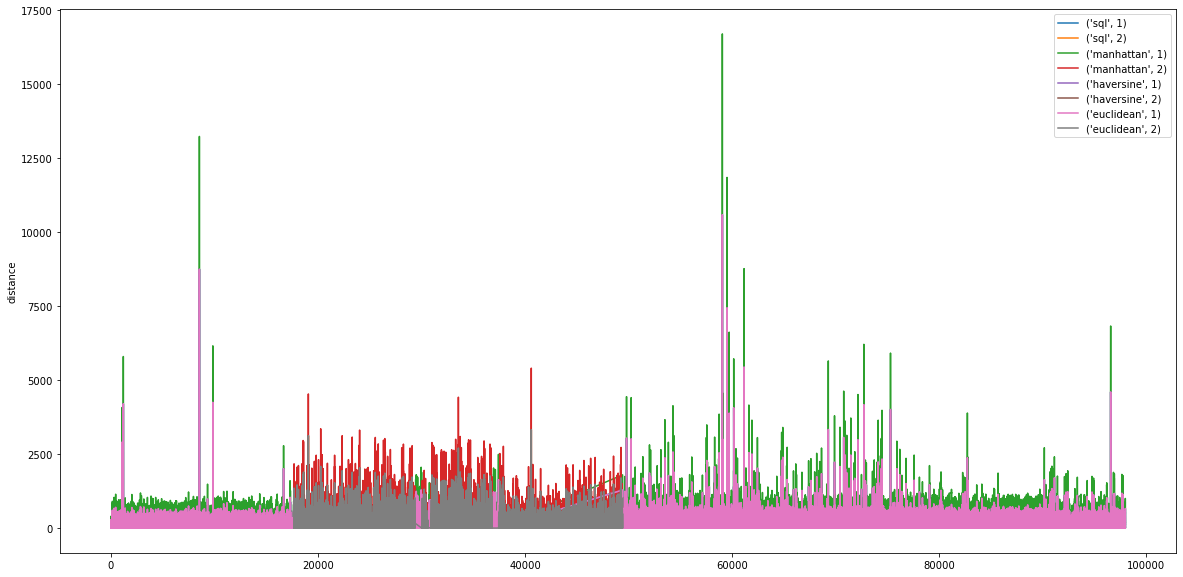

<AxesSubplot:xlabel='method', ylabel='distance'>

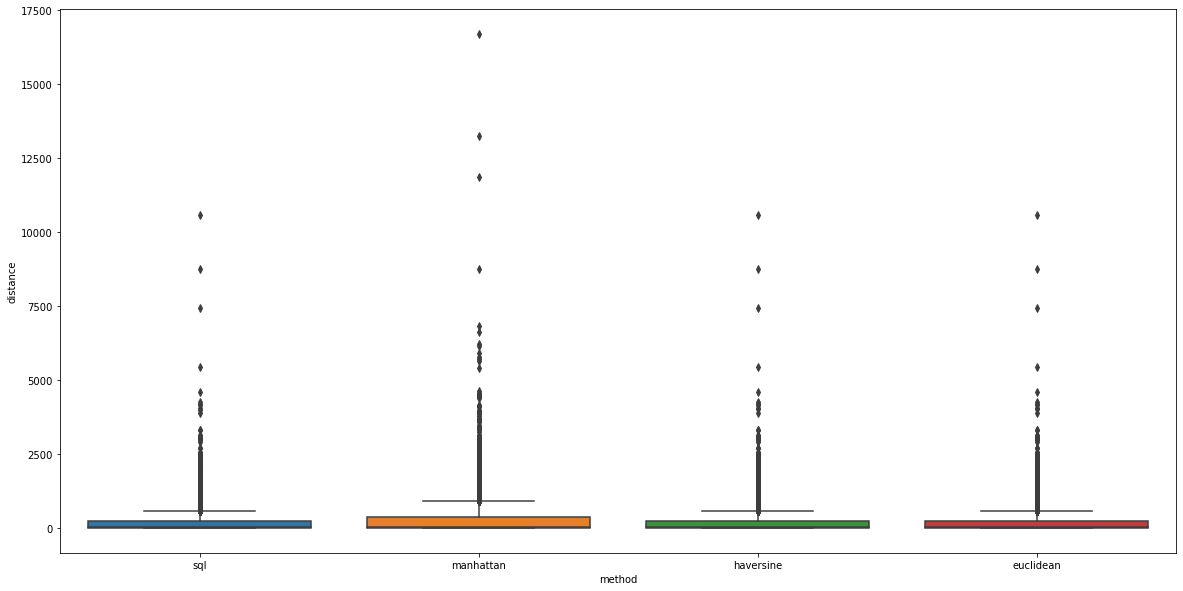

time: 11.3 s (started: 2022-07-21 13:25:26 +02:00)


In [39]:
lists_methods = np.array(['sql','manhattan','haversine','euclidean'])
lists_methods = np.repeat(lists_methods, [df_filtered.shape[0], df_filtered.shape[0], df_filtered.shape[0], df_filtered.shape[0]], axis = 0)
lists_results = list(df_filtered.dx)+list(df_filtered.custom_distance_manhattan)+ list(df_filtered.custom_distance_haversine)+list(df_filtered.custom_distance_euclidean)
list_zones = list(df_filtered.zone_id)*4
df_plot = pd.DataFrame(zip(lists_methods, lists_results, list_zones), columns = ['method','distance','zone_id'])
plt.figure(figsize = (20,10))
sns.lineplot(x = list(range(df_filtered.shape[0]))*4, y = 'distance', data = df_plot, hue = df_plot[['method','zone_id']].apply(tuple, axis =1))
plt.show()
plt.figure(figsize = (20,10))
sns.boxplot(x = 'method', y = 'distance', hue = 'zone_id', data = df_plot)

<AxesSubplot:xlabel='method', ylabel='error'>

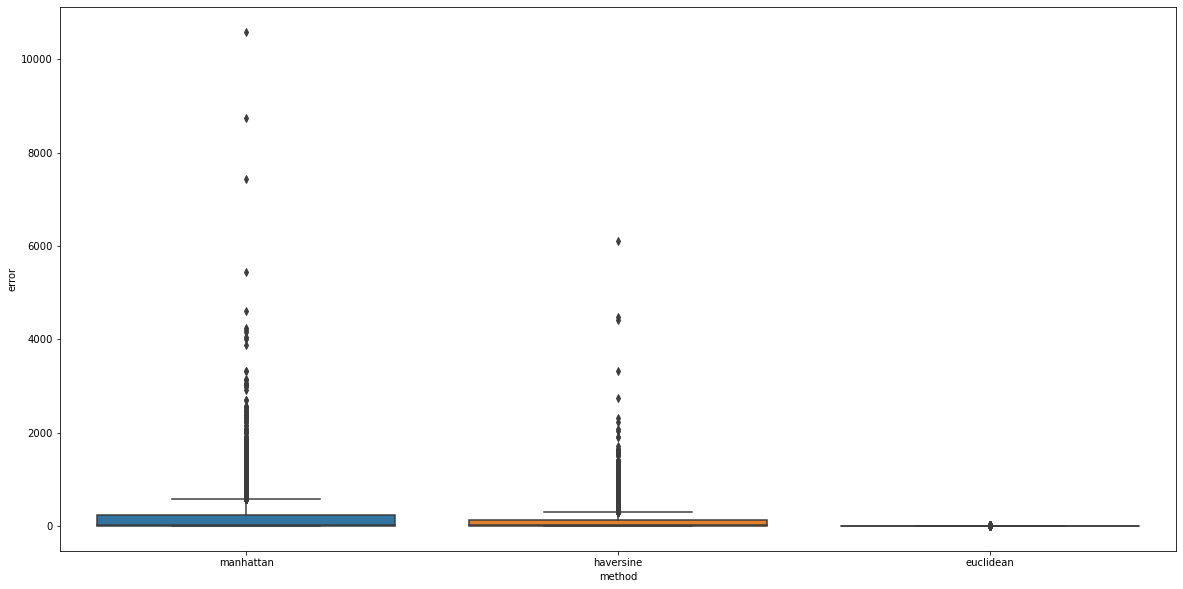

time: 490 ms (started: 2022-07-21 12:33:37 +02:00)


In [34]:
lists_methods = np.array(['manhattan','haversine','euclidean'])
lists_methods = np.repeat(lists_methods,[df_filtered.shape[0], df_filtered.shape[0], df_filtered.shape[0]], axis = 0)
lists_results = list(df_filtered.dx)+list(df_filtered.abs_manhattan_error)+ list(df_filtered.abs_haversine_error)+list(df_filtered.abs_euclidean_error)
df_plot = pd.DataFrame(zip(lists_methods, lists_results), columns = ['method','error'])
plt.figure(figsize = (20,10))
sns.boxplot(x = 'method', y = 'error', data = df_plot)

* Times dispersion